# Temperature forcasting using RNNs

## Importing libraries

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Data Preprocessing

### Getting the dataset

In [3]:
dataset = pd.read_csv('jena_climate_2009_2016.csv')
dataset.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


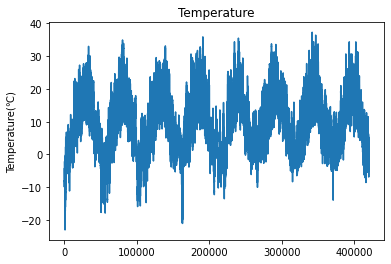

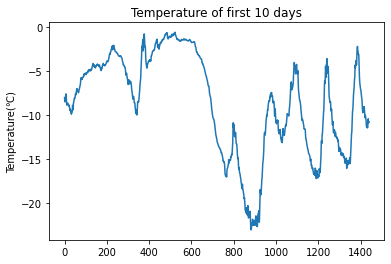

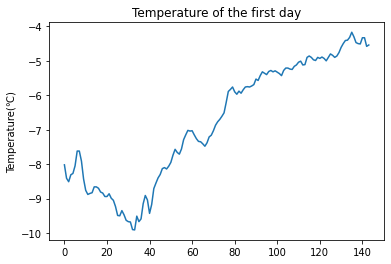

In [3]:
temp = dataset.iloc[:, 2].values
plt.figure(1)
plt.plot(temp)
plt.ylabel('Temperature(\u2103)')
plt.title('Temperature')

plt.figure(2)
plt.plot(range(1440), temp[:1440])
plt.ylabel('Temperature(\u2103)')
plt.title('Temperature of first 10 days')

plt.figure(3)
plt.plot(range(144), temp[:144])
plt.ylabel('Temperature(\u2103)')
plt.title('Temperature of the first day')


plt.show()

### Normalizing data

In [4]:
float_data = dataset.iloc[:, 1:].values
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

### RNN Data Generator

In [5]:
def generator(data, lookback, delay, max_index, min_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

# Preparing train, validation and test generaters

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      batch_size=batch_size, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step)

val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    batch_size=batch_size, 
                    min_index=200001, 
                    max_index=300000, 
                    shuffle=True, 
                    step=step)

test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     batch_size=batch_size, 
                     min_index=300001, 
                     max_index=None, 
                     shuffle=True, 
                     step=step)

val_steps = (250000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 250001 - lookback) // batch_size

## Models

### Common sense baseline

In [6]:
def evaluate_naive_baseline():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return(np.mean(batch_maes))

mae = evaluate_naive_baseline()

In [7]:
celcius_mae = mae * std[1]
print(celcius_mae)

2.5688914083113454


### Basic Neural Net approach

In [8]:
basicModel = Sequential()
basicModel.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
basicModel.add(Dense(32, activation='relu'))
basicModel.add(Dense(1))
basicModel.compile(optimizer='rmsprop', loss='mae')
history = basicModel.fit(train_gen, steps_per_epoch=200000 // 128, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/20
1562/1562 [==============================] - 35s 22ms/step - loss: 0.6976 - val_loss: 0.2981
Epoch 2/20
1562/1562 [==============================] - 24s 15ms/step - loss: 0.2585 - val_loss: 0.3106
Epoch 3/20
1562/1562 [==============================] - 23s 14ms/step - loss: 0.2336 - val_loss: 0.3125
Epoch 4/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.2221 - val_loss: 0.3212
Epoch 5/20
1562/1562 [==============================] - 22s 14ms/step - loss: 0.2129 - val_loss: 0.3625
Epoch 6/20
1562/1562 [==============================] - 23s 14ms/step - loss: 0.2053 - val_loss: 0.3500
Epoch 7/20
1562/1562 [==============================] - 23s 15ms/step - loss: 0.2001 - val_loss: 0.3430
Epoch 8/20
1562/1562 [==============================] - 23s 15ms/step - loss: 0.1954 - val_loss: 0.3374
Epoch 9/20
1562/1562 [============================

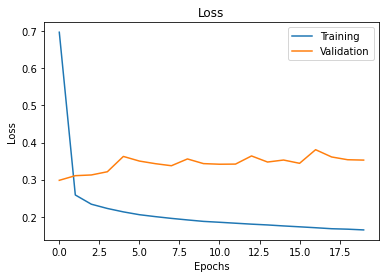

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(5)
plt.plot(loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Using LSTM Approach

In [9]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=200000 // 128, epochs=15, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/15
1562/1562 [==============================] - 210s 134ms/step - loss: 0.2884 - val_loss: 0.2653
Epoch 2/15
1562/1562 [==============================] - 204s 130ms/step - loss: 0.2689 - val_loss: 0.2747
Epoch 3/15
1562/1562 [==============================] - 205s 131ms/step - loss: 0.2542 - val_loss: 0.2728
Epoch 4/15
1562/1562 [==============================] - 204s 131ms/step - loss: 0.2398 - val_loss: 0.2875
Epoch 5/15
1562/1562 [==============================] - 205s 131ms/step - loss: 0.2278 - val_loss: 0.2967
Epoch 6/15
1562/1562 [==============================] - 205s 131ms/step - loss: 0.2170 - val_loss: 0.3013
Epoch 7/15
1562/1562 [==============================] - 204s 131ms/step - loss: 0.2084 - val_loss: 0.3089
Epoch 8/15
1562/1562 [==============================] - 206s 132ms/step - loss: 0.1997 - val_loss: 0.3099
Epoch 9/15
1562/1562 [==============================] - 206s 132ms/step - loss: 0.1932 - val_loss: 0.3117
Epoch 10/15
1562/1562 [=======================

In [10]:
model.save('recurrent_baseline.h5')

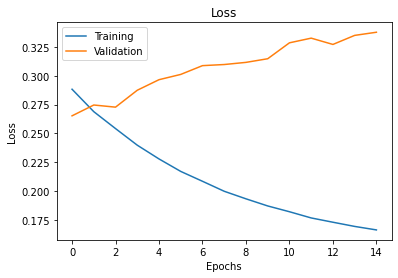

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(6)
plt.plot(loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
celcius_mae = std[1] * val_loss[2]
celcius_mae

2.4151112021214485

In [21]:
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=200000 // 128, epochs=25, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/25
1562/1562 [==============================] - 230s 147ms/step - loss: 0.3181 - val_loss: 0.2667
Epoch 2/25
1562/1562 [==============================] - 227s 146ms/step - loss: 0.2997 - val_loss: 0.2698
Epoch 3/25
1562/1562 [==============================] - 228s 146ms/step - loss: 0.2940 - val_loss: 0.2724
Epoch 4/25
1562/1562 [==============================] - 228s 146ms/step - loss: 0.2904 - val_loss: 0.2642
Epoch 5/25
1562/1562 [==============================] - 228s 146ms/step - loss: 0.2871 - val_loss: 0.2671
Epoch 6/25
1562/1562 [==============================] - 231s 148ms/step - loss: 0.2843 - val_loss: 0.2682
Epoch 7/25
1562/1562 [==============================] - 266s 170ms/step - loss: 0.2820 - val_loss: 0.2662
Epoch 8/25
1562/1562 [==============================] - 243s 156ms/step - loss: 0.2797 - val_loss: 0.2642
Epoch 9/25
1562/1562 [==============================] - 234s 150ms/step - loss: 0.2772 - val_loss: 0.2623
Epoch 10/25
1562/1562 [=======================

In [22]:
model.save('using_recurrent_dropout')

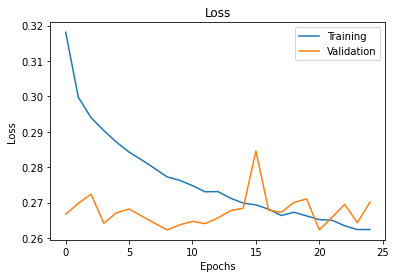

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(7)
plt.plot(loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
celcius_mae = val_loss[20] * std[1]
celcius_mae

2.3221094421494244